In [19]:
import sys
sys.path.append('..')

In [20]:
import pandas as pd
import numpy as np
import numpy.typing as npt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,label_binarize
from src.pipeline import preprocessor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
def load_data():
    df = pd.read_csv('../data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])
    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_data()

X_train_processed = torch.tensor(preprocessor.fit_transform(X_train).toarray(), dtype=torch.float32)
X_test_processed = torch.tensor(preprocessor.transform(X_test).toarray(), dtype=torch.float32)

In [ ]:
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = torch.tensor(ohe.fit_transform(y_train), dtype=torch.float32)
y_test_ohe = torch.tensor(ohe.transform(y_test), dtype=torch.float32)

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train.values.flatten())
y_test_labels = le.transform(y_test.values.flatten())

In [25]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fnn(x)
        return x

In [ ]:
def fit_neural_network(
        model, optimizer, criterion,
        X: npt.NDArray, y: npt.NDArray, epochs: int, batch_size: int):
    
    n_batches = np.ceil(len(X) / batch_size).astype(np.int32)
    max_acc = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"epoch {epoch+1}/{epochs}")
        permutation_idx = torch.randperm(X.size(0))
        X_shuffled = X[permutation_idx]
        y_shuffled = y[permutation_idx]

        running_loss = 0.0
        for i in range(0, X.size(0), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
        f1s = f1_score(y_test_labels, y_pred, average='weighted')
        acc = accuracy_score(y_test_labels, y_pred)
        print(f"f1: {f1s:.3f}\tacc: {acc:.3f}")
        if acc > max_acc:
            max_acc = acc
            torch.save(model, 'best_model.pt')

        running_loss = 0

In [27]:
model = FNN(X_train_processed.shape[1], 3)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [28]:
fit_neural_network(model, optimizer, criterion, X_train_processed, y_train_ohe, epochs=500, batch_size=128)

epoch 1/500
f1: 0.483	acc: 0.627
epoch 2/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 3/500
f1: 0.483	acc: 0.627
epoch 4/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 5/500
f1: 0.483	acc: 0.627
epoch 6/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 7/500
f1: 0.483	acc: 0.627
epoch 8/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 9/500
f1: 0.496	acc: 0.633
epoch 10/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.529	acc: 0.646
epoch 11/500
f1: 0.555	acc: 0.658
epoch 12/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.574	acc: 0.670
epoch 13/500
f1: 0.584	acc: 0.676
epoch 14/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.593	acc: 0.680
epoch 15/500
f1: 0.593	acc: 0.682
epoch 16/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.595	acc: 0.681
epoch 17/500
f1: 0.600	acc: 0.686
epoch 18/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.605	acc: 0.687
epoch 19/500
f1: 0.619	acc: 0.691
epoch 20/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.634	acc: 0.695
epoch 21/500
f1: 0.652	acc: 0.704
epoch 22/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.669	acc: 0.712
epoch 23/500
f1: 0.675	acc: 0.716
epoch 24/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.682	acc: 0.717
epoch 25/500
f1: 0.687	acc: 0.719
epoch 26/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.689	acc: 0.720
epoch 27/500
f1: 0.691	acc: 0.721
epoch 28/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.695	acc: 0.724
epoch 29/500
f1: 0.696	acc: 0.723
epoch 30/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.700	acc: 0.727
epoch 31/500
f1: 0.706	acc: 0.729
epoch 32/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.727
epoch 33/500
f1: 0.702	acc: 0.728
epoch 34/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.730
epoch 35/500
f1: 0.710	acc: 0.731
epoch 36/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.730
epoch 37/500
f1: 0.707	acc: 0.731
epoch 38/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.730
epoch 39/500
f1: 0.711	acc: 0.730
epoch 40/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.732
epoch 41/500
f1: 0.706	acc: 0.729
epoch 42/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.732
epoch 43/500
f1: 0.715	acc: 0.734
epoch 44/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.733
epoch 45/500
f1: 0.716	acc: 0.734
epoch 46/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.735
epoch 47/500
f1: 0.716	acc: 0.734
epoch 48/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.734
epoch 49/500
f1: 0.715	acc: 0.734
epoch 50/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.733
epoch 51/500
f1: 0.717	acc: 0.733
epoch 52/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.730
epoch 53/500
f1: 0.714	acc: 0.729
epoch 54/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.730
epoch 55/500
f1: 0.716	acc: 0.731
epoch 56/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.730
epoch 57/500
f1: 0.715	acc: 0.731
epoch 58/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.730
epoch 59/500
f1: 0.712	acc: 0.727
epoch 60/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.730
epoch 61/500
f1: 0.711	acc: 0.725
epoch 62/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 63/500
f1: 0.714	acc: 0.728
epoch 64/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 65/500
f1: 0.715	acc: 0.729
epoch 66/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 67/500
f1: 0.714	acc: 0.728
epoch 68/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.730
epoch 69/500
f1: 0.713	acc: 0.727
epoch 70/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 71/500
f1: 0.711	acc: 0.726
epoch 72/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 73/500
f1: 0.713	acc: 0.727
epoch 74/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 75/500
f1: 0.713	acc: 0.728
epoch 76/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.729
epoch 77/500
f1: 0.713	acc: 0.728
epoch 78/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 79/500
f1: 0.715	acc: 0.728
epoch 80/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 81/500
f1: 0.713	acc: 0.727
epoch 82/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.728
epoch 83/500
f1: 0.715	acc: 0.729
epoch 84/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 85/500
f1: 0.717	acc: 0.731
epoch 86/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 87/500
f1: 0.712	acc: 0.727
epoch 88/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 89/500
f1: 0.715	acc: 0.729
epoch 90/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 91/500
f1: 0.713	acc: 0.727
epoch 92/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.728
epoch 93/500
f1: 0.714	acc: 0.729
epoch 94/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 95/500
f1: 0.713	acc: 0.727
epoch 96/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 97/500
f1: 0.715	acc: 0.727
epoch 98/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.727
epoch 99/500
f1: 0.713	acc: 0.727
epoch 100/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 101/500
f1: 0.713	acc: 0.725
epoch 102/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 103/500
f1: 0.715	acc: 0.726
epoch 104/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 105/500
f1: 0.714	acc: 0.727
epoch 106/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 107/500
f1: 0.715	acc: 0.730
epoch 108/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 109/500
f1: 0.713	acc: 0.727
epoch 110/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 111/500
f1: 0.719	acc: 0.732
epoch 112/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.728
epoch 113/500
f1: 0.715	acc: 0.730
epoch 114/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.727
epoch 115/500
f1: 0.713	acc: 0.728
epoch 116/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.731
epoch 117/500
f1: 0.716	acc: 0.730
epoch 118/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 119/500
f1: 0.715	acc: 0.728
epoch 120/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 121/500
f1: 0.713	acc: 0.726
epoch 122/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 123/500
f1: 0.715	acc: 0.730
epoch 124/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.728
epoch 125/500
f1: 0.714	acc: 0.728
epoch 126/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 127/500
f1: 0.716	acc: 0.730
epoch 128/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.731
epoch 129/500
f1: 0.714	acc: 0.728
epoch 130/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 131/500
f1: 0.716	acc: 0.730
epoch 132/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 133/500
f1: 0.712	acc: 0.727
epoch 134/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 135/500
f1: 0.714	acc: 0.729
epoch 136/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 137/500
f1: 0.713	acc: 0.727
epoch 138/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 139/500
f1: 0.714	acc: 0.727
epoch 140/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.727
epoch 141/500
f1: 0.714	acc: 0.727
epoch 142/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 143/500
f1: 0.712	acc: 0.723
epoch 144/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.726
epoch 145/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 146/500
f1: 0.713	acc: 0.726
epoch 147/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 148/500
f1: 0.714	acc: 0.727
epoch 149/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 150/500
f1: 0.713	acc: 0.727
epoch 151/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.728
epoch 152/500
f1: 0.713	acc: 0.725
epoch 153/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.728
epoch 154/500
f1: 0.711	acc: 0.724
epoch 155/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 156/500
f1: 0.713	acc: 0.729
epoch 157/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 158/500
f1: 0.715	acc: 0.728
epoch 159/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 160/500
f1: 0.713	acc: 0.725
epoch 161/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 162/500
f1: 0.713	acc: 0.727
epoch 163/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.729
epoch 164/500
f1: 0.714	acc: 0.728
epoch 165/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.726
epoch 166/500
f1: 0.713	acc: 0.726
epoch 167/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 168/500
f1: 0.712	acc: 0.725
epoch 169/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 170/500
f1: 0.715	acc: 0.728
epoch 171/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 172/500
f1: 0.713	acc: 0.726
epoch 173/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.731
epoch 174/500
f1: 0.716	acc: 0.730
epoch 175/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 176/500
f1: 0.713	acc: 0.725
epoch 177/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 178/500
f1: 0.713	acc: 0.727
epoch 179/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 180/500
f1: 0.714	acc: 0.726
epoch 181/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.731
epoch 182/500
f1: 0.714	acc: 0.726
epoch 183/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 184/500
f1: 0.714	acc: 0.725
epoch 185/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.732
epoch 186/500
f1: 0.715	acc: 0.727
epoch 187/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.730
epoch 188/500
f1: 0.715	acc: 0.727
epoch 189/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.726
epoch 190/500
f1: 0.715	acc: 0.726
epoch 191/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 192/500
f1: 0.714	acc: 0.726
epoch 193/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.730
epoch 194/500
f1: 0.719	acc: 0.732
epoch 195/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 196/500
f1: 0.720	acc: 0.732
epoch 197/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 198/500
f1: 0.714	acc: 0.725
epoch 199/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 200/500
f1: 0.715	acc: 0.726
epoch 201/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 202/500
f1: 0.715	acc: 0.726
epoch 203/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 204/500
f1: 0.717	acc: 0.730
epoch 205/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 206/500
f1: 0.714	acc: 0.727
epoch 207/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 208/500
f1: 0.710	acc: 0.723
epoch 209/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 210/500
f1: 0.713	acc: 0.725
epoch 211/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 212/500
f1: 0.711	acc: 0.724
epoch 213/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.722
epoch 214/500
f1: 0.709	acc: 0.722
epoch 215/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 216/500
f1: 0.707	acc: 0.721
epoch 217/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 218/500
f1: 0.710	acc: 0.724
epoch 219/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.721
epoch 220/500
f1: 0.711	acc: 0.723
epoch 221/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.724
epoch 222/500
f1: 0.710	acc: 0.723
epoch 223/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.722
epoch 224/500
f1: 0.711	acc: 0.725
epoch 225/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 226/500
f1: 0.712	acc: 0.728
epoch 227/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.722
epoch 228/500
f1: 0.710	acc: 0.722
epoch 229/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 230/500
f1: 0.711	acc: 0.724
epoch 231/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.721
epoch 232/500
f1: 0.710	acc: 0.723
epoch 233/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 234/500
f1: 0.711	acc: 0.724
epoch 235/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 236/500
f1: 0.707	acc: 0.721
epoch 237/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 238/500
f1: 0.708	acc: 0.721
epoch 239/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.718
epoch 240/500
f1: 0.707	acc: 0.720
epoch 241/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.717
epoch 242/500
f1: 0.708	acc: 0.722
epoch 243/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.703	acc: 0.717
epoch 244/500
f1: 0.706	acc: 0.720
epoch 245/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.718
epoch 246/500
f1: 0.710	acc: 0.722
epoch 247/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.719
epoch 248/500
f1: 0.708	acc: 0.722
epoch 249/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.720
epoch 250/500
f1: 0.707	acc: 0.721
epoch 251/500
f1: 0.703	acc: 0.715
epoch 252/500
f1: 0.706	acc: 0.720
epoch 253/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement '

f1: 0.705	acc: 0.719
epoch 254/500
f1: 0.705	acc: 0.718
epoch 255/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.717
epoch 256/500
f1: 0.703	acc: 0.716
epoch 257/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.721
epoch 258/500
f1: 0.707	acc: 0.721
epoch 259/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.719
epoch 260/500
f1: 0.706	acc: 0.719
epoch 261/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 262/500
f1: 0.708	acc: 0.721
epoch 263/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 264/500
f1: 0.708	acc: 0.721
epoch 265/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.721
epoch 266/500
f1: 0.703	acc: 0.717
epoch 267/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.719
epoch 268/500
f1: 0.706	acc: 0.719
epoch 269/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.719
epoch 270/500
f1: 0.709	acc: 0.721
epoch 271/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.702	acc: 0.715
epoch 272/500
f1: 0.704	acc: 0.718
epoch 273/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.721
epoch 274/500
f1: 0.705	acc: 0.719
epoch 275/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.702	acc: 0.717
epoch 276/500
f1: 0.704	acc: 0.717
epoch 277/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.717
epoch 278/500
f1: 0.704	acc: 0.718
epoch 279/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.717
epoch 280/500
f1: 0.707	acc: 0.719
epoch 281/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.719
epoch 282/500
f1: 0.704	acc: 0.717
epoch 283/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.718
epoch 284/500
f1: 0.704	acc: 0.719
epoch 285/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.718
epoch 286/500
f1: 0.707	acc: 0.720
epoch 287/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.717
epoch 288/500
f1: 0.705	acc: 0.719
epoch 289/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.718
epoch 290/500
f1: 0.705	acc: 0.719
epoch 291/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 292/500
f1: 0.706	acc: 0.719
epoch 293/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.721
epoch 294/500
f1: 0.707	acc: 0.721
epoch 295/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.719
epoch 296/500
f1: 0.705	acc: 0.718
epoch 297/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.718
epoch 298/500
f1: 0.704	acc: 0.718
epoch 299/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.719
epoch 300/500
f1: 0.704	acc: 0.718
epoch 301/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.718
epoch 302/500
f1: 0.706	acc: 0.720
epoch 303/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.719
epoch 304/500
f1: 0.706	acc: 0.718
epoch 305/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.718
epoch 306/500
f1: 0.707	acc: 0.720
epoch 307/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.719
epoch 308/500
f1: 0.707	acc: 0.720
epoch 309/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.720
epoch 310/500
f1: 0.707	acc: 0.721
epoch 311/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 312/500
f1: 0.708	acc: 0.721
epoch 313/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 314/500
f1: 0.709	acc: 0.723
epoch 315/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 316/500
f1: 0.708	acc: 0.721
epoch 317/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 318/500
f1: 0.710	acc: 0.724
epoch 319/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.721
epoch 320/500
f1: 0.710	acc: 0.722
epoch 321/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.725
epoch 322/500
f1: 0.711	acc: 0.725
epoch 323/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 324/500
f1: 0.707	acc: 0.719
epoch 325/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.722
epoch 326/500
f1: 0.707	acc: 0.719
epoch 327/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 328/500
f1: 0.707	acc: 0.721
epoch 329/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.720
epoch 330/500
f1: 0.708	acc: 0.720
epoch 331/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 332/500
f1: 0.708	acc: 0.720
epoch 333/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 334/500
f1: 0.707	acc: 0.721
epoch 335/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.722
epoch 336/500
f1: 0.706	acc: 0.719
epoch 337/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 338/500
f1: 0.710	acc: 0.724
epoch 339/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 340/500
f1: 0.711	acc: 0.723
epoch 341/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 342/500
f1: 0.710	acc: 0.723
epoch 343/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.724
epoch 344/500
f1: 0.712	acc: 0.726
epoch 345/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.724
epoch 346/500
f1: 0.709	acc: 0.722
epoch 347/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.721
epoch 348/500
f1: 0.710	acc: 0.724
epoch 349/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 350/500
f1: 0.709	acc: 0.721
epoch 351/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 352/500
f1: 0.710	acc: 0.724
epoch 353/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.720
epoch 354/500
f1: 0.706	acc: 0.719
epoch 355/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 356/500
f1: 0.709	acc: 0.723
epoch 357/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 358/500
f1: 0.711	acc: 0.723
epoch 359/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 360/500
f1: 0.712	acc: 0.725
epoch 361/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 362/500
f1: 0.711	acc: 0.723
epoch 363/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 364/500
f1: 0.709	acc: 0.722
epoch 365/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 366/500
f1: 0.709	acc: 0.723
epoch 367/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 368/500
f1: 0.711	acc: 0.724
epoch 369/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 370/500
f1: 0.708	acc: 0.723
epoch 371/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 372/500
f1: 0.710	acc: 0.722
epoch 373/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 374/500
f1: 0.707	acc: 0.721
epoch 375/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 376/500
f1: 0.709	acc: 0.722
epoch 377/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 378/500
f1: 0.708	acc: 0.722
epoch 379/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 380/500
f1: 0.711	acc: 0.724
epoch 381/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.724
epoch 382/500
f1: 0.711	acc: 0.724
epoch 383/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 384/500
f1: 0.710	acc: 0.723
epoch 385/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 386/500
f1: 0.711	acc: 0.724
epoch 387/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 388/500
f1: 0.712	acc: 0.724
epoch 389/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 390/500
f1: 0.711	acc: 0.724
epoch 391/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 392/500
f1: 0.711	acc: 0.723
epoch 393/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 394/500
f1: 0.710	acc: 0.723
epoch 395/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.724
epoch 396/500
f1: 0.708	acc: 0.721
epoch 397/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 398/500
f1: 0.710	acc: 0.723
epoch 399/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 400/500
f1: 0.711	acc: 0.723
epoch 401/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 402/500
f1: 0.713	acc: 0.725
epoch 403/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 404/500
f1: 0.708	acc: 0.722
epoch 405/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.721
epoch 406/500
f1: 0.711	acc: 0.725
epoch 407/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.723
epoch 408/500
f1: 0.709	acc: 0.723
epoch 409/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 410/500
f1: 0.712	acc: 0.725
epoch 411/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.727
epoch 412/500
f1: 0.710	acc: 0.722
epoch 413/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.725
epoch 414/500
f1: 0.711	acc: 0.725
epoch 415/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 416/500
f1: 0.709	acc: 0.722
epoch 417/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 418/500
f1: 0.711	acc: 0.724
epoch 419/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.722
epoch 420/500
f1: 0.710	acc: 0.723
epoch 421/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 422/500
f1: 0.712	acc: 0.725
epoch 423/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 424/500
f1: 0.710	acc: 0.723
epoch 425/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 426/500
f1: 0.709	acc: 0.723
epoch 427/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 428/500
f1: 0.710	acc: 0.724
epoch 429/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 430/500
f1: 0.710	acc: 0.723
epoch 431/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 432/500
f1: 0.713	acc: 0.726
epoch 433/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 434/500
f1: 0.710	acc: 0.723
epoch 435/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 436/500
f1: 0.711	acc: 0.724
epoch 437/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 438/500
f1: 0.709	acc: 0.724
epoch 439/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.724
epoch 440/500
f1: 0.709	acc: 0.723
epoch 441/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 442/500
f1: 0.712	acc: 0.726
epoch 443/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 444/500
f1: 0.712	acc: 0.725
epoch 445/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 446/500
f1: 0.712	acc: 0.723
epoch 447/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 448/500
f1: 0.710	acc: 0.725
epoch 449/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 450/500
f1: 0.708	acc: 0.721
epoch 451/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.722
epoch 452/500
f1: 0.708	acc: 0.721
epoch 453/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.722
epoch 454/500
f1: 0.711	acc: 0.724
epoch 455/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 456/500
f1: 0.710	acc: 0.723
epoch 457/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 458/500
f1: 0.709	acc: 0.722
epoch 459/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.720
epoch 460/500
f1: 0.711	acc: 0.725
epoch 461/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 462/500
f1: 0.710	acc: 0.723
epoch 463/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 464/500
f1: 0.710	acc: 0.723
epoch 465/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.723
epoch 466/500
f1: 0.708	acc: 0.721
epoch 467/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 468/500
f1: 0.709	acc: 0.723
epoch 469/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 470/500
f1: 0.712	acc: 0.725
epoch 471/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 472/500
f1: 0.710	acc: 0.723
epoch 473/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 474/500
f1: 0.709	acc: 0.721
epoch 475/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 476/500
f1: 0.709	acc: 0.722
epoch 477/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.721
epoch 478/500
f1: 0.712	acc: 0.726
epoch 479/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 480/500
f1: 0.712	acc: 0.725
epoch 481/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 482/500
f1: 0.710	acc: 0.724
epoch 483/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 484/500
f1: 0.710	acc: 0.723
epoch 485/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 486/500
f1: 0.710	acc: 0.723
epoch 487/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 488/500
f1: 0.709	acc: 0.722
epoch 489/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 490/500
f1: 0.710	acc: 0.725
epoch 491/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 492/500
f1: 0.712	acc: 0.726
epoch 493/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.722
epoch 494/500
f1: 0.710	acc: 0.723
epoch 495/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 496/500
f1: 0.709	acc: 0.721
epoch 497/500


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 498/500
f1: 0.709	acc: 0.723
epoch 499/500
f1: 0.709	acc: 0.722
epoch 500/500
f1: 0.708	acc: 0.723


C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_52440\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


In [29]:
model = torch.load("best_model.pt", weights_only=False)
model.eval()

y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))

accuracy_score(y_test_labels, y_pred)
f1_score(y_test_labels, y_pred, average='weighted')

C:\temp\ipykernel_52440\2439682726.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


0.7180035849426266

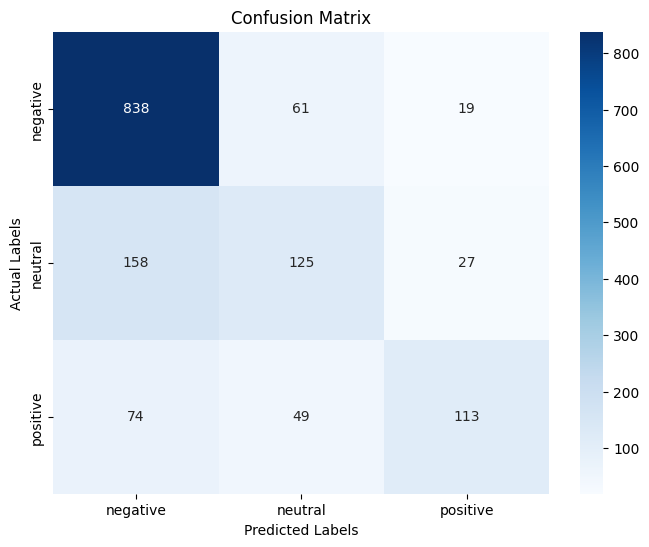

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

C:\temp\ipykernel_52440\472587763.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))


Accuracy on training data: 0.7604
Accuracy on test data: 0.7350

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.78      0.91      0.84       918
     neutral       0.53      0.40      0.46       310
    positive       0.71      0.48      0.57       236

    accuracy                           0.73      1464
   macro avg       0.68      0.60      0.62      1464
weighted avg       0.72      0.73      0.72      1464



C:\temp\ipykernel_52440\472587763.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))


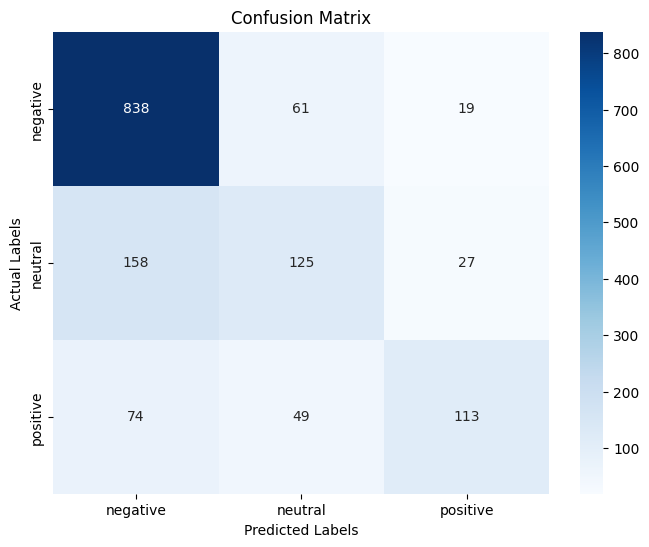

In [ ]:
y_train_pred = model(X_train_processed)
y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))
train_accuracy = accuracy_score(y_train_labels, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

y_test_pred = model(X_test_processed)
y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")
print("\nClassification report for the test data:")
print(classification_report(y_test_labels, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_labels, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Area under the curve (AUC)

In [32]:
model.eval()

with torch.no_grad():
    y_pred_probs = model(X_test_processed) 

y_pred_probs = y_pred_probs.cpu().numpy()  

In [ ]:
num_classes = 3
y_test_onehot = label_binarize(y_test_labels, classes=[0, 1, 2])  

In [ ]:
auc_ovr_weighted = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="weighted")
print("Weighted One-vs-Rest AUC:", auc_ovr_weighted)

Weighted One-vs-Rest AUC: 0.8336777740063563


# Gini Coefficient

In [35]:
gini_ovr_weighted = 2 * auc_ovr_weighted - 1
print("Weighted One-vs-Rest Gini:", gini_ovr_weighted)

Weighted One-vs-Rest Gini: 0.6673555480127127


In [36]:
auc_per_class = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average=None)

gini_per_class = 2 * auc_per_class - 1

for i, (auc_val, gini_val) in enumerate(zip(auc_per_class, gini_per_class)):
    print(f"Class {i}: AUC={auc_val:.3f}, Gini={gini_val:.3f}")

Class 0: AUC=0.849, Gini=0.699
Class 1: AUC=0.772, Gini=0.544
Class 2: AUC=0.854, Gini=0.708
